In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('../train.csv',index_col="tripid")

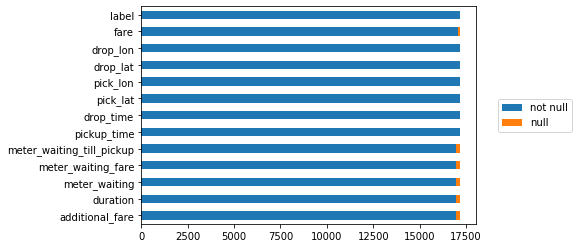

In [3]:
ax = pd.DataFrame({'not null': train_df.count(),
                   'null': train_df.isnull().sum()}).plot.barh(stacked=True)

ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5)
)

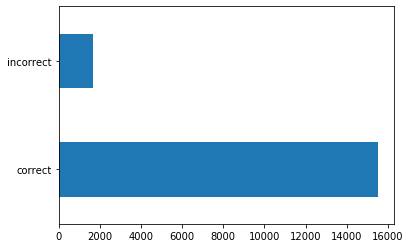

In [4]:
train_df['label'].value_counts().plot.barh()

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler

RANDOM_SEED = 42  

In [6]:
labels_raw_df = train_df.loc[:, train_df.columns == 'label']
features_raw_df = train_df.drop(columns=['label'])

In [7]:
def preprocess_labels(input_labels_df):
  labels_df = input_labels_df
  labels_df = pd.DataFrame(label_binarize(labels_df, classes=['incorrrect', 'correct']))
  
  labels_df.columns = labels_df.columns
  labels_df.index = labels_df.index

  return labels_df  

In [8]:
labels_df = preprocess_labels(labels_raw_df)

In [74]:
def preprocess_features(input_features_df):
    features_df = input_features_df.copy()
    
    #date time
    features_df['pickup_time'] = pd.to_datetime(features_df['pickup_time'])
    features_df['drop_time'] = pd.to_datetime(features_df['drop_time'])
    
    #duration
    features_df['duration_fill'] = (features_df['drop_time'] - features_df['pickup_time']).dt.total_seconds()
    features_df['duration'] = features_df['duration'].fillna(features_df['duration_fill'])
    
    features_df = features_df.drop(columns=['duration_fill'])

    #travel time
    features_df['travel_time'] = features_df['duration'] - features_df['meter_waiting']
    
    #waiting time
    features_df['waiting_time'] = features_df['meter_waiting'] + features_df['meter_waiting_till_pickup']
    
    #distance fare
    features_df['distance_fare'] = features_df['fare'] - features_df['meter_waiting_fare'] - features_df['additional_fare']
   
    #distance
    features_df['manhattan_distance'] = abs(features_df['drop_lat'] - features_df['pick_lat']) + abs(features_df['drop_lon'] - features_df['pick_lon'])

    #get day of the week
    features_df['pickup_day_of_week'] = features_df['pickup_time'].dt.day_name()
    features_df['drop_day_of_week'] = features_df['drop_time'].dt.day_name()
    
    features_df['pickup_hour_float'] = features_df['pickup_time'].dt.hour + features_df['pickup_time'].dt.minute/60
    features_df['drop_hour_float'] = features_df['drop_time'].dt.hour + features_df['drop_time'].dt.minute/60

    
    #encode cyclic 24 hours with sin and cos
    features_df['sin_pickup_time'] = np.sin(2*np.pi*features_df.pickup_hour_float/24.)
    features_df['cos_pickup_time'] = np.cos(2*np.pi*features_df.pickup_hour_float/24.)

    features_df['sin_drop_time'] = np.sin(2*np.pi*features_df.drop_hour_float/24.)
    features_df['cos_drop_time'] = np.cos(2*np.pi*features_df.drop_hour_float/24.)
    
    features_df = pd.get_dummies(features_df, columns = ['pickup_day_of_week', 'drop_day_of_week'])
    
    features_df = features_df.drop(columns=['pickup_time','drop_time', 'pickup_hour_float', 'drop_hour_float'])
    
    numeric_cols = features_df.columns[features_df.dtypes != "object"].values
    
    non_numeric_cols = features_df.columns[features_df.dtypes == "object"].values
    
    #numeric
    scaler = MinMaxScaler()
    features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

    imputer = SimpleImputer(strategy='mean')
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])
    
    return features_df

In [75]:
features_df = preprocess_features(features_raw_df)

In [76]:
test_features_raw_df = pd.read_csv('../test.csv',index_col="tripid")
test_features_df = preprocess_features(test_features_raw_df)

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.2,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [149]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_eval, label=y_eval)

In [129]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score

def f1(y_pred, dtrain):
  print(dtrain)
  y_true = dtrain.get_label()
  err = 1 - f1_score(y_true, np.round(y_pred))
  return 'f1', err

def f1_macro(y_pred, dtrain):
  print(dtrain)
  y_true = dtrain.get_label()
  err = 1 - f1_score(y_true, np.round(y_pred), average='macro')
  return 'f1_macro', err

In [130]:
from bayes_opt import BayesianOptimization

def bo_tune_xgb(max_depth, min_split_loss, n_estimators ,learning_rate, subsample, min_child_weight):
    params = {
    'learning_rate': learning_rate, 
    'min_split_loss': min_split_loss,
    'n_estimators': int(n_estimators), 
    'objective': 'binary:logistic', 
    'max_depth': int(max_depth), 
    'min_child_weight': min_child_weight,
    'subsample': subsample,
    'num_parallel_tree' : 5,
    'nthread' : -1}

    cv_result = xgb.cv(
                        params,
                        dtrain,
                        seed=42,
                        nfold=5,
                        feval = f1,
                        early_stopping_rounds=10,
                        verbose_eval=0
                    )
    

    return -1.0 * cv_result['test-f1-mean'].iloc[-1]

In [131]:
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (5, 10),
                                            'min_split_loss': (0, 1),
                                            'learning_rate':(0,1),
                                            'n_estimators':(70,140),
                                            'subsample' :(0.5,1),
                                            'min_child_weight' : (0,5)
                                            })

In [132]:
xgb_bo.maximize(init_points=5, n_iter=8, acq='ei', xi=0.0)

|   iter    |  target   | learni... | max_depth | min_ch... | min_sp... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.02943  |  0.8341   |  6.08     |  3.509    |  0.2197   |  129.1    |  0.5229   |


|  2        | -0.02866  |  0.6003   |  9.877    |  3.253    |  0.6314   |  126.9    |  0.6679   |
|  3        | -0.03292  |  0.06339  |  5.905    |  1.051    |  0.5809   |  135.8    |  0.7344   |


|  4        | -0.03009  |  0.1571   |  6.725    |  1.331    |  0.8117   |  133.7    |  0.6306   |
|  5        | -0.03084  |  0.06084  |  6.252    |  2.072    |  0.1144   |  131.8    |  0.5026   |


|  6        | -0.0295   |  0.2037   |  9.569    |  4.525    |  0.2819   |  70.08    |  0.7236   |
|  7        | -0.0292   |  0.1874   |  9.567    |  0.241    |  0.7529   |  70.02    |  0.5446   |


|  8        | -0.02905  |  0.8663   |  9.545    |  4.643    |  0.4526   |  70.13    |  0.7408   |
|  9        | -0.02912  |  0.9832   |  9.966    |  4.157    |  0.9888   |  70.02    |  0.6284   |


|  10       | -0.03017  |  0.4131   |  5.378    |  4.465    |  0.1629   |  70.02    |  0.9823   |


|  11       | -0.0293   |  0.3146   |  9.963    |  4.602    |  0.2511   |  70.12    |  0.9721   |
|  12       | -0.02897  |  0.5794   |  9.945    |  4.941    |  0.1384   |  70.04    |  0.5148   |


|  13       | -0.02826  |  0.9999   |  9.768    |  0.6339   |  0.2513   |  70.05    |  0.9211   |


In [133]:
xgb_bo.max

{'target': -0.028255799999999998,
 'params': {'learning_rate': 0.9998745844599641,
  'max_depth': 9.768222468357145,
  'min_child_weight': 0.6338742737222747,
  'min_split_loss': 0.25126009744790223,
  'n_estimators': 70.05178600250606,
  'subsample': 0.9211001436001498}}

In [134]:
params = {
    'learning_rate': 0.2, 
    'min_split_loss': 0.2,
    'n_estimators': 100, 
    'objective': 'binary:logistic', 
    'max_depth': 6, 
    'min_child_weight': 2, 
    'subsample': 1,
    'num_parallel_tree' : 5,
    'nthread' : -1}

for k in (xgb_bo.max['params']):
    params[k] = xgb_bo.max['params'][k]
    
params

{'learning_rate': 0.9998745844599641,
 'min_split_loss': 0.25126009744790223,
 'n_estimators': 70.05178600250606,
 'objective': 'binary:logistic',
 'max_depth': 9.768222468357145,
 'min_child_weight': 0.6338742737222747,
 'subsample': 0.9211001436001498,
 'num_parallel_tree': 5,
 'nthread': -1}

In [137]:
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

In [139]:
print(f"F1 Score: {1-cv_results['test-f1-mean'].min()}")

F1 Score: 0.97197


In [136]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    feval = f1,
    early_stopping_rounds=10,
    verbose_eval=0
)

In [106]:
1-cv_results['test-f1-mean'].min() #0.2

0.9719182

In [153]:
model = XGBClassifier(**params).fit(X_train, y_train.values.ravel())

In [155]:
y_pred = model.predict(X_eval)

thresh = .5
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0

from sklearn.metrics import f1_score

print('F1 Score = {:.6f}'.format(f1_score(y_eval, y_pred)))
print('Macro F1 Score = {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 Score = 0.972973
Macro F1 Score = 0.840438


In [127]:
y_pred = model.predict(xgb.DMatrix(X_eval))

thresh = .5
y_pred [y_pred > thresh] = 1
y_pred [y_pred <= thresh] = 0

from sklearn.metrics import f1_score

print('F1 Score = {:.6f}'.format(f1_score(y_eval, y_pred)))
print('Macro F1 Score = {:.6f}'.format(f1_score(y_eval, y_pred, average='macro')))

F1 Score = 0.972733
Macro F1 Score = 0.833884


In [114]:
feature_importnace = model.get_score(importance_type='gain')

<function matplotlib.pyplot.show(*args, **kw)>

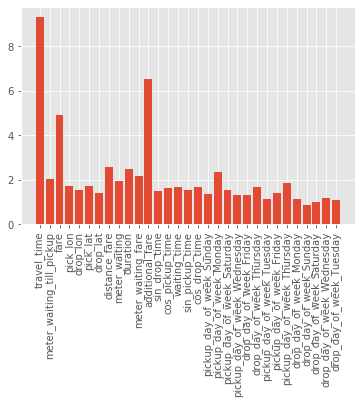

In [115]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.bar(range(len(feature_importnace)), list(feature_importnace.values()), align='center')
plt.xticks(range(len(feature_importnace)), list(feature_importnace.keys()), rotation='vertical')

plt.show

In [158]:
def predict_test_set(model, test_features_df, submission_no):
    global thresh
    
    test_pred = model.predict(test_features_df)
    
    test_pred [test_pred > thresh] = 1
    test_pred [test_pred <= thresh] = 0
    
    submission_df = pd.read_csv('../sample_submission.csv',index_col="tripid")
    
    # Make sure we have the rows in the same order
    np.testing.assert_array_equal(test_features_df.index.values, submission_df.index.values)
    
    # Save predictions to submission data frame
    submission_df["prediction"] = test_pred
    
    submission_df['prediction'] = submission_df['prediction'].astype(int)

    submission_df.to_csv(f'../submission{submission_no}.csv', index=True)

In [159]:
predict_test_set(model, test_features_df, 10)

In [156]:
model


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.9998745844599641, max_delta_step=0, max_depth=9,
              min_child_weight=0.6338742737222747,
              min_split_loss=0.25126009744790223, missing=None, n_estimators=70,
              n_jobs=1, nthread=-1, num_parallel_tree=5,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9211001436001498, verbosity=1)

In [ ]:
s9 = pd.read_csv('../submission8.csv',index_col="tripid")

In [ ]:
s10 = pd.read_csv('../submission11.csv',index_col="tripid")

In [ ]:
s = abs(s10['prediction'] - s9['prediction'])

In [ ]:
s

In [ ]:
s.sum()